In [1]:
#need some cutouts and coordinates
from astropy.nddata import Cutout2D
from astropy import coordinates
from astropy import units as u

#if you want to try this with various images, glob is the answer for finding files!
import glob
# filenames = glob.glob('../../Convolved_Images_Hub/*126_image*')
# print(filenames)

#some common packages
import numpy as np
from astropy import wcs
from astropy.convolution import convolve, Gaussian2DKernel, Box2DKernel
from astropy.io import fits
import pandas as pd
from reproject import reproject_exact  #a package that can be added to astropy using anaconda or pip (see their docs pg)
from reproject import reproject_interp
import sys

#easiest option would be using a library...assuming it works...but it doesn't?:(
# from statsmodels.distributions.empirical_distribution import ECDF


In [2]:


# This dictionary defines a colormap in case you want to make a unique colormap?
cdict = {'red':  ((0.0, 0.0, 0.0), (0.5, 1.0, 1.0), (1.0, 0.8, 0.8)), 'green': ((0.0, 0.8, 0.8), (0.5, 1.0, 1.0), (1.0, 0.0, 0.0)), 'blue':  ((0.0, 0.0, 0.0), (0.5, 1.0, 1.0), (1.0, 0.0, 0.0)) } # no red at 0
# all channels set to 1.0 at 0.5 to create white
# set to 0.8 so its not too bright at 1

# set to 0.8 so its not too bright at 0
# all channels set to 1.0 at 0.5 to create white
# no green at 1

# no blue at 0
# all channels set to 1.0 at 0.5 to create white
# no blue at 1


# Creating a colormap using the dictionary
import matplotlib.colors as colors
GnRd = colors.LinearSegmentedColormap('GnRd', cdict)


#a plotting code to review what we're analyzing while in python
#data is the input data
#w is the wcs
#wcscond is True or False, True means the axes will be in RA/Dec, and False means axes in pixels
import matplotlib.pyplot as plt
def implot(data, w, wcscond, vmax_p):
    fig = plt.figure()

    if  wcscond == True:
        fig.add_subplot(111, projection=w)
    else:
        fig.add_subplot(111)

    #for christmas turn on GnRd
    #plt.cm.get_cmap('Blues', 6) is another option
    #can also use RdBu...
    #otherwise just use plt.cm.viridis b/c it's not bad
    plt.imshow(data, origin='lower', cmap=plt.cm.viridis, vmin =0, vmax=vmax_p)
    plt.xlabel('RA')
    plt.ylabel('Dec')


#determining cutout coordinates for each knot...so far just do it by eye and in pixel space
#could probably do it in wcs coords, RA/DEC, but I couldn't get that working

def file_open(file):
    hdu1 = fits.open(file)  #import image
    w = wcs.WCS(hdu1[0].header)   #get wcs coords
    data = hdu1[0].data  #getting data from hdu
    hdu1.close()

    return w, data

In [3]:
# In[5]:

'''now convolve my image with a PSF of the image we're projecting ONTO
an approx PSF can be found by assuming a 2D Gaussian func with a width (a FWHM) of the diffrac limit
that is the st dev of the Gaussian is about the st dev is about = lambda/D
a list of PSFs are found on https://docs.astropy.org/en/stable/convolution/kernels.html

Notes:
FIRST: always must convert hdu1_pixtorad to radians! It's inconsistent otherwise, and lambda/D is generally in radians

what we're using for the gaussian width is the FWHM, not the radius of the first ring of the diffraction pattern,
so it's 1.2 not 1.22 times lambda/D

D is 85 cm for spitzer
D is 2.4 m for hubble
'''


def im_conv(low_res_name, D, hdu_pix_torad, hdu_dat, kern):
    #unfortuantely no good way to find wavelength from header right now. can enter it manually, but I tried to automate it

    #reading in excel file of wavelengths...right now needs to be in same directory as this code
    #first col is a substring of the fits image file name, the second col is the wavelengths in microns
    df = pd.read_excel('../imglams.xlsx')
    cols = df.columns
    cols_str = [str(i) for i in df[cols[0]]]
    #some test cases I was using

    #gaussian kernel
    if kern == 'gauss':
        #this finds the loc in the excel file where the image substring matches our image name
        #it then finds the wavelength value corresponding to that loc
        lam =  df.loc[np.where([i in low_res_name for i in cols_str])[0][0]].values[1] #lambda in microns

        #finding angular resolution...the FWHM of our Gaussian PSF
        res = 1.2 * lam / D         #resolution in radians
        res = res / hdu_pix_torad        #so converting to pixels

        #finding PSF and then calculating the convolution of our image and the PSF of the image we're projecting onto
        kernel = Gaussian2DKernel(res)

    #box kernel
    if kern == 'box':
        kernel = Box2DKernel(16.)

    hdu_conv = convolve(hdu_dat, kernel)
    return hdu_conv


# In[27]:

#setting up a new fits file to be saved and viewed in DS9
#primarily to save the image we reprojected, but can also be used to save the convolved images
def fits_saver(array, wcs_header, name, save_path):
    '''
    array is a 2d array of data - could be from reprojecting one image onto another or from convolution
    wcs_header is a header containing the wcs coords of the image that we projected onto or of the orig image (if from the convolution)
    name is the path to some image you're using. It will get string split at the / character, and the func only takes the last element of that splitting
    save_path is the folder you want to save to...recommended to also add something to the start of the images names to make it clear what you did to them (e.g. 'Regridded/regrid_')
    '''

    #creating a new file and adding the reprojected array of data as well as the WCS that we projected onto
    hdu_new = fits.PrimaryHDU(array, header=wcs_header)
    hdul = fits.HDUList([hdu_new])

    #saving the file
    new_filename = name.split('/')[-1]  #grabs the file name we were using from before
    hdul.writeto(save_path+new_filename, overwrite=True)

    return (save_path+new_filename)


In [4]:
#only saving the fits files
def cutout_saver(filenames, pos, size, name, save=False):
    for file in filenames:
        hdu1 = fits.open(file)  #import image
        w = wcs.WCS(hdu1[1].header)   #get wcs coords
    #     print(w.array_shape)
    #     w = wcs.utils.wcs_to_celestial_frame(w)

        #cuting out data and wcs
        data = hdu1[1].data
        cutout = Cutout2D(data, position, size, wcs = w.celestial)
        datacut = cutout.data
        wcscut = cutout.wcs
    #     print(wcscut.is_celestial)

        #updating header with WCS info
        newhead = hdu1[0].header.update(wcscut.to_header())
        hdu1.close()

        #plottinga
        implot(datacut, wcscut, False, np.mean(datacut))
    #     implot(data, new_wcs)     #plot
    #     plt.savefig('datacut.png')
    #     sys.exit()


        #saving full fits file...
        if save == True:
            lamnum = file[file.index('build')-3:file.index('build')]
            fits.writeto('hh_cutouts/'+name+lamnum+".fits", datacut, wcscut.to_header(), overwrite=True)
        #     fits.writeto('HH6_'+lamnum+".fits", datacut, newhead, overwrite=True)

        #     output_hdul = new_wcs.to_fits()
        #     output_hdul[0].data = data
        #     output_hdul.writeto('HH6_'+file[:3]+".fits", overwrite=True)
        #     sys.exit()

SystemExit: 

C:\Users\arubi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3426: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


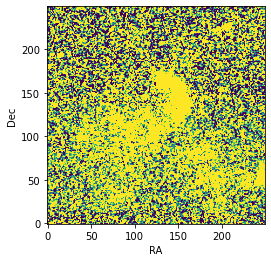

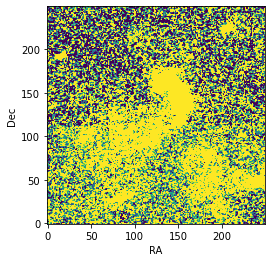

In [5]:
#the hubble images
files_units = ['../../ngc1333_fits/126build_shift_2_drz.fits', '../../ngc1333_fits/164build_shift_2_drz.fits']
hdu_list = [fits.open(i) for i in files_units]
hdu_header_list = [fits.open(i)[0].header for i in files_units]

#IMPORTANT: first load in file to cutout of...
# filenames = files_units #glob.glob('../../ngc1333_fits/*drz.fits') #normally glob is convenient, but here we only doing x2
# print(filenames)

# '''
# HH 5: 7095.485, 1391.142
# '''
# position = (7095.485, 1391.142)  #x, y!
# size = (220, 220)  #y, x!...necessary b/c of how cutout works
# name = 'hh5_lam'
# cutout_saver(files_units, position, size, name, save=True)
# '''

# '''
# # HH 6:
# # # '''
# position = (4725, 2875)  #x, y!
# size = (240, 300)  #y, x!...necessary b/c of how cutout works
# name = 'hh6_lam'
# cutout_saver(files_units, position, size, name, save=True)
# '''
# HH 711:
# '''
# position = (6124.0401,3215.233)  #x, y!
# size = (959,1054)  #y, x!...necessary b/c of how cutout works
# name = 'hh711_lam'
# cutout_saver(files_units, position, size, name, save=True)
# '''
# HH 13: 10539.368, 3924.647
# '''
# position = (10539.368, 3924.647)  #x, y!
# size = (220, 220)  #y, x!...necessary b/c of how cutout works
# name = 'hh13_lam'
# cutout_saver(files_units, position, size, name, save=True)
# '''
# HH 15: 9773.224, 2878.197
# '''
# position = (9773.224, 2878.197)  #x, y!
# size = (250, 250)  #y, x!...necessary b/c of how cutout works
# name = 'hh15_lam'
# cutout_saver(files_units, position, size, name, save=True)
# '''
# '''
# HH 16:
# '''
# position = (9081.8719, 2105.2402)  #x, y!
# size = (70, 150)  #y, x!...necessary b/c of how cutout works
# name = 'hh16_lam'
# cutout_saver(files_units, position, size, name, save=True)
# # '''
# # HH 17: looks like a star
# # '''
# position = (4512.2483, 2073.0366)  #x, y!
# size = (250, 250)  #y, x!...necessary b/c of how cutout works
# name = 'hh19_lam'
# cutout_saver(files_units, position, size, name, save=True)
# # '''
# # '''
# # HH 18: Cutoff from image:(
# # '''
# # HH 340:
# # '''
# position = (11240.533, 3900.8797)  #x, y!
# size = (200, 150)  #y, x!...necessary b/c of how cutout works
# name = 'hh340_lam'
# cutout_saver(files_units, position, size, name, save=True)
# # '''
# # HH 341: 9335.032, 3892.378
# # '''
position = (9335.032, 3892.378)  #x, y!
size = (250, 250)  #y, x!...necessary b/c of how cutout works
name = 'hh341_lam'
cutout_saver(files_units, position, size, name, save=True)
# # '''
# # HH 342: Cutoff by pixel:(
# # '''



# In[21]:
#EX: grabbing all the fits image paths in a directory, so they can be looped through and their data opened
#set your path to some directory with images (the images can be in subdirectories)
#using ** will grab all files even in subdirectories...WARNING this will take longer

#initializing some lists to be used
hdu_pix_list = []
hdu_pixtorad_list = []
hdu_fnu_list = []
hdu_flam_list = []
hdu_bw_list = []
hdu_data_list = []
hdu_header_list = []

 #defining new list for the actual image we're using...
im_names_hh5 = ['hh_cutouts/hh5_lam126.fits', 'hh_cutouts/hh5_lam164.fits']
im_names_hh6 = ['hh_cutouts/hh6_lam126.fits', 'hh_cutouts/hh6_lam164.fits']
im_names_hh711 = ['hh_cutouts/hh711_lam126.fits', 'hh_cutouts/hh711_lam164.fits']
im_names_hh13 = ['hh_cutouts/hh13_lam126.fits', 'hh_cutouts/hh13_lam164.fits']
im_names_hh15 = ['hh_cutouts/hh15_lam126.fits', 'hh_cutouts/hh15_lam164.fits']
im_names_hh16 = ['hh_cutouts/hh16_lam126.fits', 'hh_cutouts/hh16_lam164.fits']
im_names_hh340 = ['hh_cutouts/hh340_lam126.fits', 'hh_cutouts/hh340_lam164.fits']
im_names_hh341 = ['hh_cutouts/hh341_lam126.fits', 'hh_cutouts/hh341_lam164.fits']
im_picks_list = [im_names_hh5, im_names_hh6, im_names_hh711, im_names_hh13, im_names_hh15, im_names_hh16, 
                     im_names_hh340, im_names_hh341]



#looping through chosen HHs and regridding
hdu_header1 = hdu_list[1][1].header
hdu_header2 = hdu_list[1][1].header
w = wcs.WCS(hdu_header2)

for name, name2 in im_picks_list:
    #reading in files
    hdu1 = fits.open(name) #126
    hdu_header1 = hdu1[0].header
    hdu2 = fits.open(name2) #164
    hdu_header2 = hdu2[0].header
    w = wcs.WCS(hdu_header2)
    
    hdu_pix1 = (hdu_list[0][0].header['D001SCAL'])  #D001SCAL is the keyword for Hubble images, in sr
    hdu_pixtorad1 = (hdu_pix1 / 206265.)
    hdu_flam1 = (hdu_list[0][0].header['PHOTFLAM'])
    hdu_bw1 = (hdu_list[0][0].header['PHOTBW'])

    hdu_pix2 = (hdu_list[1][0].header['D001SCAL'])  #D001SCAL is the keyword for Hubble images, in sr
    hdu_pixtorad2 = (hdu_pix2 / 206265.)
    hdu_flam2 = (hdu_list[1][0].header['PHOTFLAM'])
    hdu_bw2 = (hdu_list[1][0].header['PHOTBW'])
    
    #reading in data for general use  and header for wcs
    #converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
    hdu1_data = hdu1[0].data * hdu_flam1 * hdu_bw1
    hdu2_data = hdu2[0].data * hdu_flam2 * hdu_bw2

    #convolving images
    D = 2.4 #that of Hubble, in m
    D *= 1e6 #converting to microns since x m / 1 m * 1E6 microns gets microns, the unit of our wavelength file
    
    hdu1_conv = im_conv(name, D, hdu_pixtorad1, hdu1_data, 'gauss')
    hdu1_conv = im_conv(name, D, hdu_pixtorad2, hdu1_conv, 'gauss')
    hdu2_conv = im_conv(name2, D, hdu_pixtorad2, hdu2_data, 'gauss')
    hdu2_conv = im_conv(name2, D, hdu_pixtorad1, hdu2_conv, 'gauss')

    #converting the convolved image to correct units and saving it so we can reproject it
    #conversion needed for hubble case since units are not in terms of surface brightness
#     hdu1_conv_scaled = hdu1_conv   #dividing out sr, D001SCAL is key for pixel size in arcsec
    hdu2_conv_scaled = hdu2_conv  / hdu_pixtorad2**2. #dividing out sr, D001SCAL is key for pixel size in arcsec

    #you'll need to set the WCS to be that of the header you're basing this off of...ie the header
    file_start = '../Convolved_Images_Hub/conv_'
    conv1_path = fits_saver(hdu1_conv, hdu_header1, name, file_start)
    conv2_path = fits_saver(hdu2_conv_scaled, hdu_header2, name2, file_start)


    #reprojection of one hdu using the header (coords and pixels) of another
    #The first input is the path to the file we're reprojecting. The second input is the header of the image we're projecting ONTO
    #para is False for large images (like these hubble ones)
    #output is array (a 2D array of data) and footprint (the footprint from the analysis)
    para = False
    array, footprint = reproject_exact(conv2_path, w, shape_out=hdu1_conv.shape, parallel=para)

    file_start = '../Regridded_Hub/regrid_'
    regrid_2_path = fits_saver(array * hdu_pixtorad1**2., hdu_header1, name2, file_start)
    regrid_2_foot_path = fits_saver(footprint * hdu_pixtorad1**2., hdu_header1, name2, file_start+'footprint_')


    # In[21]:
    #declaring noise: measured from the RMS of a region of empty sky while opening the image in DS9
    #these are newly taken from the HH 6 images...
    noise_126 = 0.0465246*1e-16
    noise_164 = 0.0561296*1e-16

    #now that we have a reprojected hubble image for hdu2 and both are convolved, need to
    #divide one by the other...then can use the same wcs header that we projected onto (hdu1's)!

    #the signal to noise cutoff? can try with and without
    flux01 = hdu1_conv
    flux02 = array * hdu_pixtorad1**2.

    perc = 0.2 #this tends to work?? Maybe can change...
    flux01[flux01/noise_126 < perc] = np.nan
    flux02[flux02/noise_164 < perc] = np.nan

    #saving just each separate image with the noise filter on
    save_path = 'hh_filtered/'
    fits_saver(flux01, hdu_header1, name.split('/')[1].split('_')[0]+'_126_ston_'+str(perc)+'.fits', save_path)
    fits_saver(flux02, hdu_header1, name.split('/')[1].split('_')[0]+'_164_ston_'+str(perc)+'.fits', save_path)

    # remember to have the right header with the wcs below and that it matches the one we're projecting ONTO
    data_ratio = np.divide(flux01, flux02, out=np.zeros_like(flux02), where=flux02!=0.) #need to do np.divide to guarantee we get no divide by zero issue...
    save_path = 'hh_div_moreratios/regrid_'  #See fits_saver's "save_path" description for explanation
    fits_saver(data_ratio, hdu_header1, name.split('/')[1].split('_')[0]+'_ston_'+str(perc)+'.fits', save_path)  #saving the reprojected image


sys.exit()


#specifically for HH 7_11
hh711_path = '../../ngc1333_fits/Background_corr/'
hdu1_hh711 = fits.open(hh711_path + 'background_corr_' + '126' + '_aligned.fits')
hdu2_hh711 = fits.open(hh711_path + 'background_corr_' + '164' + '_aligned.fits')

#reading in conversions
hdu_pix1 = (hdu_list[0][0].header['D001SCAL'])  #D001SCAL is the keyword for Hubble images, in sr
hdu_pixtorad1 = (hdu_pix1 / 206265.)

hdu_pix2 = (hdu_list[1][0].header['D001SCAL'])  #D001SCAL is the keyword for Hubble images, in sr
hdu_pixtorad2 = (hdu_pix2 / 206265.)

#reading in data for general use  and header for wcs, background corrected
hdu1_data = hdu1_hh711[0].data
hdu2_data = hdu2_hh711[0].data
#converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above


#first convolve (already regridded)
D = 2.4 #that of Hubble, in m
D *= 1e6 #converting to microns since x m / 1 m * 1E6 microns gets microns, the unit of our wavelength file

hdu1_conv = im_conv('background_corr_' + '126' + '_aligned.fits', D, hdu_pixtorad1, hdu1_data, 'gauss')
hdu1_conv = im_conv('background_corr_' + '126' + '_aligned.fits', D, hdu_pixtorad2, hdu1_conv, 'gauss')
hdu2_conv = im_conv('background_corr_' + '164' + '_aligned.fits', D, hdu_pixtorad2, hdu2_data, 'gauss')
hdu2_conv = im_conv('background_corr_' + '164' + '_aligned.fits', D, hdu_pixtorad1, hdu2_conv, 'gauss')

#now divide and filter...
perc = 0.8 #this tends to work?? Maybe can change...
noise_126 = 2.6e-18
noise_164 = 5.766e-18
# hdu1_conv[hdu1_conv/noise_126 < perc] = np.nan
# hdu2_conv[hdu2_conv/noise_164 < perc] = np.nan
hdu1_conv[hdu1_conv <= 5e-18] = np.nan
hdu2_conv[hdu2_conv <= 5e-18] = np.nan

# remember to have the right header with the wcs below and that it matches the one we're projecting ONTO
hdu_header1 = hdu1_hh711[0].header

#saving the noise filtered images for hh 7-11
save_path = 'hh_div_moreratios/'
fits_saver(hdu1_conv, hdu_header1, name.split('/')[1].split('_')[0]+'_126_ston_'+str(perc)+'.fits', save_path)
fits_saver(hdu2_conv, hdu_header1, name.split('/')[1].split('_')[0]+'_164_ston_'+str(perc)+'.fits', save_path)

#saving the divided image
data_ratio = np.divide(hdu1_conv, hdu2_conv, out=np.zeros_like(hdu2_conv), where=hdu2_conv!=0.) #need to do np.divide to guarantee we get no divide by zero issue...
# save_path = 'hh_div/conv_'  #See fits_saver's "save_path" description for explanation
# fits_saver(data_ratio, hdu_header1, 'hh711_'+'_ston_'+str(perc)+'.fits', save_path)  #saving the reprojected image